In [1]:
import skimage.io
import matplotlib.pyplot as plt
import numpy as np
import os
import json
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skimage import feature
from skimage.feature import corner_harris, corner_subpix, corner_peaks


In [213]:
def load_microwave_volume(input_file):
        """
        Load microwave volume from tiff file. Each provided volume contains three slices in propagation direction. The
        provided microwave volumes are given in linear scale.

        :param string input_file: Path to tiff file
        :return ndarray: Image as ndarray with shape MxNx3
        """

        return skimage.io.imread(input_file)


In [334]:
def visualize_microwave_volume(input_file, dynamic_range=25, label=None):
        """
        Visualize the slices of a microwave image volume in logarithmic scale with the given dynamic_range
        :param string input_file: Path to input file
        :param float dynamic_range: Dynamic range in dB (default: 25)
        """

        img = load_microwave_volume(input_file)

        if label is None:
            label_filename = input_file.replace('.tiff', '.json')
            if os.path.exists(label_filename):
                with open(label_filename, 'r') as file:
                    label = json.loads(file.read())

        fig, axs = plt.subplots(1, 3, figsize=(12, 7))
        for i in range(img.shape[2]):
            volume = 10 * np.log10(img[:, :, i])
            max_val = np.max(volume)
            axs[i].imshow(volume, vmax=max_val, vmin=max_val - dynamic_range)
            axs[i].set_title(f"Slice {i + 1:d}")

            if label is not None:
                x_coords = [coord[0] for coord in label['coordinates']['present']]
                y_coords = [257-coord[1] for coord in label['coordinates']['present']]
                axs[i].scatter(x_coords, y_coords, color='white')

                x_coords = [coord[0] for coord in label['coordinates']['missing']]
                y_coords = [257 - coord[1] for coord in label['coordinates']['missing']]
                axs[i].scatter(x_coords, y_coords, color='red')

        if label is not None:
            fig.canvas.set_window_title(f"Present pills: {len(label['coordinates']['present'])}, "
                                        f"Missing pills: {len(label['coordinates']['missing'])}")

        plt.show()


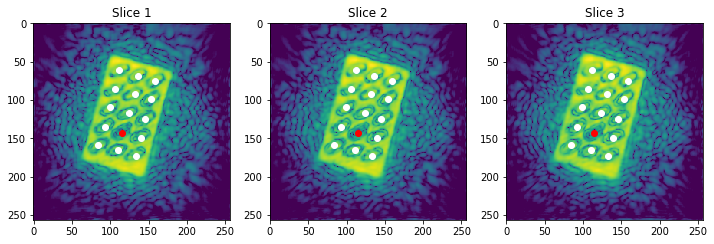

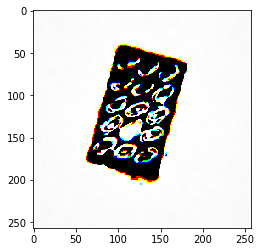

In [371]:
tiff_path = os.path.join('public_data', 'b16083e8c24627a98f85ba77a82fa0f5.tiff')
img1 = visualize_microwave_volume(tiff_path)

img = skimage.io.imread(tiff_path)
#dynamic_range = 25
rgbArray1 = np.full((257,257,3),0, 'uint8')
#fig, axs = plt.subplots(1, 3, figsize=(16, 7))
for i in range(img.shape[2]):
    rgbArray1[..., i] = 3 * np.log10(img[:, :, i])
    #rgbArray1[..., i] =  img[:, :, i]
#     max_val = np.max(rgbArray1[..., i])
#     axs[i].imshow(volume, vmax=max_val, vmin=max_val - dynamic_range)
#     rgbArray1[..., i] = volume.copy()
#     max_val = np.max(volume)
#     axs[i].imshow(volume, vmax=max_val, vmin=max_val - dynamic_range)
#     axs[i].imshow(volume)
#     axs[i].set_title(f"Slice {i + 1:d}")


plt.imshow(rgbArray1, cmap = 'gray')
# plt.show()
# plt.imshow(rgbArray1[:,:,1])
# plt.show()
# plt.imshow(rgbArray1[:,:,2])
#plt.imshow(rgbArray1)

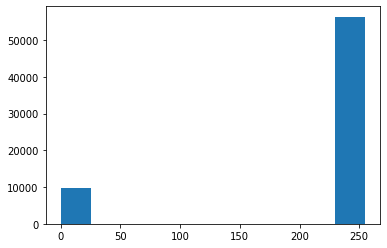

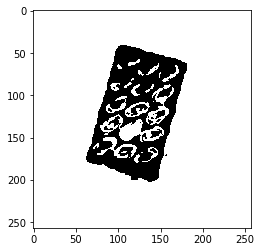

In [372]:
#rgbArray1 = cv2.GaussianBlur(rgbArray1, (1, 1), 0)

kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(rgbArray1.reshape(-1, 3))
res = kmeans.labels_.reshape(257, 257)

#res.reshape(257,257)
res = 255 * res

counts, bins, bars = plt.hist(res.flatten())


if counts[0] > counts[-1]:
    a = 255 * np.ones((257,257))
    res = a - res
res = res.astype('u1')

# res = skimage.morphology.binary_dilation(res)
res = res.astype('u1')
plt.figure()
plt.imshow(res, cmap = 'gray')

In [373]:
edges1 = feature.canny(res.reshape(257,257), sigma = 10)
coords = corner_peaks(corner_harris(edges1), min_distance=1, threshold_rel=0.1)
coords[:,[0, 1]] = coords[:,[1, 0]]

# plt.imshow(edges1.astype('u1'), cmap = 'gray')
# plt.scatter(coords[:, 0], coords[:, 1], )
    

In [374]:
rect = cv2.minAreaRect(coords)
box = cv2.boxPoints(rect)
box = np.int0(box)

top_left_x = min(box[:,1])
top_left_y = min(box[:,0])
bot_right_x = max(box[:,1])
bot_right_y = max(box[:,0])

rect = cv2.minAreaRect(coords)
box = cv2.boxPoints(rect) # cv2.boxPoints(rect) for OpenCV 3.x
box = np.int0(box)

In [375]:
width = int(rect[1][0])
height = int(rect[1][1])

src_pts = box.astype("float32")
# coordinate of the points in box points after the rectangle has been
# straightened
dst_pts = np.array([[0, height-1],
                    [0, 0],
                    [width-1, 0],
                    [width-1, height-1]], dtype="float32")

# the perspective transformation matrix
M = cv2.getPerspectiveTransform(src_pts, dst_pts)

# directly warp the rotated rectangle to get the straightened rectangle
warped = cv2.warpPerspective(res, M, (width, height))

#cv2.imwrite("crop_img.jpg", warped)

#plt.figure(figsize=(18,6))
#plt.imshow(warped, cmap= 'gray')

In [376]:
shape = warped.shape

if shape[0] > shape[1]:
    vertical = 1 #detect orientation
else:
    vertical = 0
        
max_shape = max(shape)

if max_shape <141:
    num_pills = 10
    long_dim = 135
    short_dim = 90
    x_points = [25, 70]
    y_points = [20, 45, 67, 87, 110]
    
else:
    num_pills = 15
    long_dim = 150
    short_dim = 90
    y_points= [20, 45, 70, 95, 120]
    x_points = [20, 45, 70]
    
if vertical == 1:
    dim = (short_dim, long_dim)
else:
    dim = (long_dim, short_dim)
    x_points, y_points = y_points, x_points

resized = cv2.resize(warped, dim, interpolation = cv2.INTER_AREA)    
#plt.imshow(resized)
points = np.array(np.meshgrid(x_points, y_points)).T.reshape(-1,2)
#plt.scatter(points[:,0], points[:,1], color = 'r')


In [381]:
def transform_coordinates_back(idcs, M):
    """Undoes the perspective transformation given by M on a tuple of indices idcs. idcs must have the following shape ((x1, x2, x3, ...), (y1, y2, y3, ...))"""
    # Flip and concatenate with a number 1 (it is assumed that t_i = 1 in equation in https://docs.opencv.org/4.x/da/d54/group__imgproc__transform.html#ga20f62aa3235d869c9956436c870893ae)
    # may be a source of the error
    idcs1 = np.concatenate((idcs[::-1], np.ones((1, len(idcs[0])))), axis=0)

    # Multiply with the inverse of the perspective transformation matrix
    idcs_dst = np.round(np.linalg.inv(M)@idcs1)

    # Convert to a list of tuples and flip
    idcs_dst = [tuple(lst) for lst in idcs_dst[:2].astype('u1').tolist()][::-1]
    return tuple(idcs_dst)

In [377]:
present_pills = []
missing_pills = []

for i in range(0,15):
    x,y = points[i]

    x1 = x-9
    x2 = x+9

    y1 = y-9 
    y2 = y+9

#     plt.imshow(warped[y1:y2, x1:x2 ])
#     plt.show()
#     a, b, c = plt.hist(warped[y1:y2, x1:x2 ].flatten())
#     plt.show()
    
    hist, bin_edges = np.histogram(warped[y1:y2, x1:x2 ].flatten())
    
    if hist[0] > hist [-1] + 30:
        present_pills.append(points[i])
    else: 
        missing_pills.append(points[i])
        
missing_pills = np.array(missing_pills)
present_pills = np.array(present_pills)        

In [378]:
s1 = tuple(points[:,1])
s2 = tuple(points[:,0])
s  =(s1,s2)
new = transform_coordinates_back(s, M)
combined = np.vstack((new[0], new[1])).T

#plt.imshow(img, cmap = 'gray')

#plt.scatter(combined[:,1], combined[:,0], color = 'r')

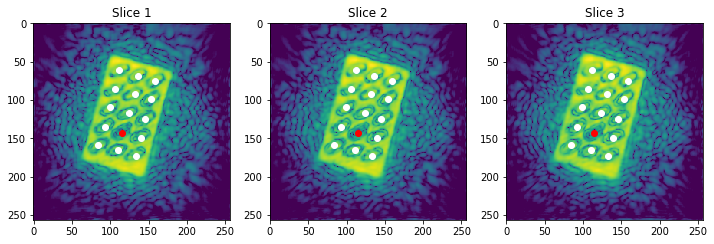

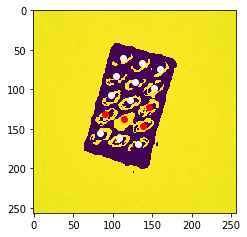

In [382]:

if len(missing_pills) != 0:
    s1 = tuple(missing_pills[:,1])
    s2 = tuple(missing_pills[:,0])
    s  =(s1,s2)
    new = transform_coordinates_back(s, M)
    combined_missing = np.vstack((new[0], new[1])).T

if len(present_pills) != 0:
    s1 = tuple(present_pills[:,1])
    s2 = tuple(present_pills[:,0])
    s  = (s1,s2)
    new = transform_coordinates_back(s, M)
    combined_present = np.vstack((new[0], new[1])).T

visualize_microwave_volume(tiff_path)
plt.show()


plt.figure(figsize=(8,5))
plt.subplot(1,2,2)
plt.imshow(rgbArray1[:,:,0])
plt.scatter(combined_missing[:,1], combined_missing[:,0], color = 'r')
plt.scatter(combined_present[:,1], combined_present[:,0], color = 'w')
plt.show()


# CODE BELOW UNDER DEV #

In [158]:
new = transform_coordinates_back(s, M)
combined = np.vstack((new[0], new[1])).T
plt.imshow(img, cmap = 'gray')
plt.scatter(combined[:,1], combined[:,0], color = 'r')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


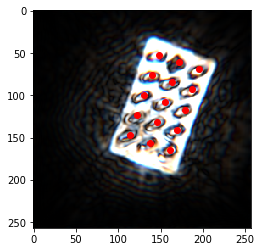

In [160]:
combined

array([[ 52, 148],
       [ 76, 140],
       [100, 131],
       [123, 122],
       [147, 114],
       [ 61, 172],
       [ 84, 163],
       [108, 155],
       [132, 146],
       [156, 138],
       [ 69, 196],
       [ 93, 187],
       [117, 179],
       [141, 170],
       [165, 161]])

In [189]:
hist, bin_edges = np.histogram(warped[y1:y2, x1:x2 ].flatten())

In [190]:
if hist[0] > hist [1] + 20:
    present_pills.append(points[i])
else: 
    missing_pills.append(points[i])

array([160,  13,  10,   9,  12,  11,  13,   8,  10,  78], dtype=int64)

In [191]:
bin_edges

array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
       229.5, 255. ])

In [97]:
hist

array([0.03449528, 0.00036311, 0.00012104, 0.00072622, 0.00108932,
       0.00048414, 0.00012104, 0.        , 0.00012104, 0.0016945 ])

In [61]:
warped[x1:x2 , y1:y2].shape

(14, 0)

(array([171.,   9.,  12.,   6.,   8.,   9.,  10.,  15.,   9.,  75.]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <a list of 10 Patch objects>)

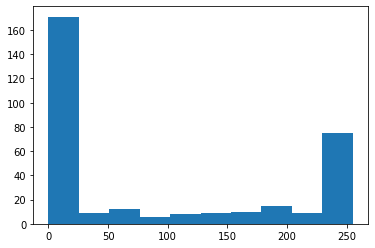

In [84]:
plt.hist(warped[y1:y2, x1:x2 ].flatten())

# Code below under dev

In [196]:
image = cv2.circle(resized, points[2] , 4, color = 150, thickness= 3)
#cv.circle(img,(447,63), 63, (0,0,255), -1)

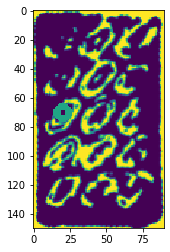

In [197]:
plt.imshow(image)

In [204]:
a1,b1 = points[0]

r= 4
cv2.circle(resized,points[0], r)
result = resized[a1-r:a1+r,b1-r:b1+r]
plt.imshow(result)
# cv2.imshow('image',img)
# cv2.imshow('result',result)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

error: OpenCV(4.5.5) :-1: error: (-5:Bad argument) in function 'circle'
> Overload resolution failed:
>  - circle() missing required argument 'color' (pos 4)
>  - circle() missing required argument 'color' (pos 4)


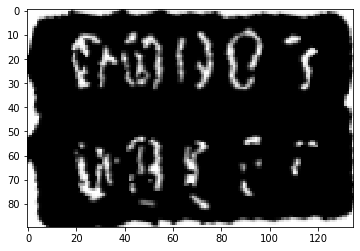

In [270]:
resized = cv2.resize(warped, (135, 90), interpolation = cv2.INTER_AREA)
#test = skimage.morphology.binary_erosion(resized)
#test = skimage.morphology.binary_erosion(test)
test = test.astype('u1') 
#Gaussian = cv2.GaussianBlur(test, (3, 3), 0)
#Gaussian = cv2.GaussianBlur(Gaussian, (5, 5), 0)
plt.imshow(resized, cmap= 'gray')

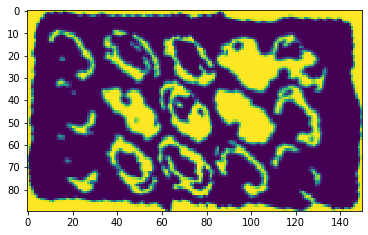

In [22]:
plt.imshow(resized)

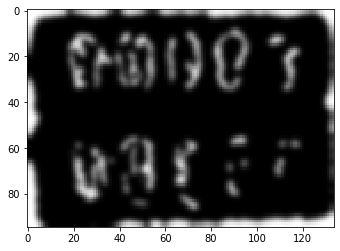

In [271]:
#bilateral = cv2.bilateralFilter(test, 13,75,75)

# bilateral = cv2.bilateralFilter(bilateral, 5,75,75)
# bilateral = cv2.bilateralFilter(bilateral, 5,75,75)

Gaussian = cv2.GaussianBlur(warped, (3, 3), 0)
Gaussian = cv2.GaussianBlur(Gaussian, (5, 5), 0)
# #Gaussian = cv2.GaussianBlur(Gaussian, (3, 3), 0)
# Gaussian = cv2.GaussianBlur(Gaussian, (7, 7), 0)
# Gaussian = cv2.GaussianBlur(Gaussian, (5, 5), 0)
# # Gaussian = cv2.GaussianBlur(Gaussian, (5, 5), 0)
# #cv2.imshow('Gaussian Blurring', Gaussian)
#test = skimage.morphology.binary_erosion(bilateral)
plt.imshow(Gaussian, cmap= 'gray')
#cv2.waitKey(0)

In [37]:
Gaussian.shape

(90, 150)

In [59]:
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(Gaussian.reshape(-1, 3))
res = kmeans.labels_.reshape(257, 257)

(133,)

In [55]:
257*257

66049

In [135]:
print(warped.shape)

(91, 150)


(array([782.,  26.,  25.,  21.,  22.,  15.,  21.,  23.,  33., 292.]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <a list of 10 Patch objects>)

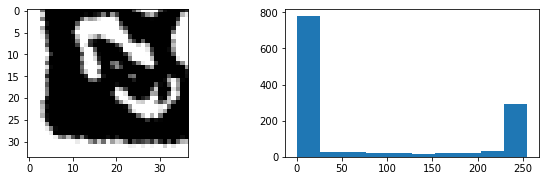

In [144]:
plt.figure(figsize=(10,6))
plt.subplot(2,2,1)
plt.imshow(warped[-35:-1,0:37], cmap = 'gray')
plt.subplot(2,2,2)
plt.hist(warped[0:35,0:36].flatten())

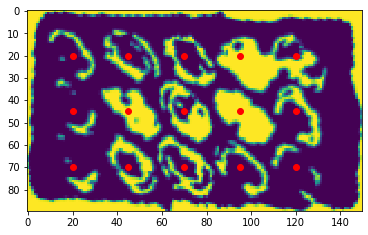

In [141]:
shape = warped.shape

if shape[0] > shape[1]:
    vertical = 1 #detect orientation
else:
    vertical = 0
        
max_shape = max(shape)

if max_shape <139:
    num_pills = 10
    long_dim = 135
    short_dim = 90
    x_points = [25, 70]
    y_points = [20, 45, 67, 87, 110]
    
else:
    num_pills = 15
    long_dim = 150
    short_dim = 90
    y_points= [20, 45, 70, 95, 120]
    x_points = [20, 45, 70]
    
if vertical == 1:
    dim = (short_dim, long_dim)
else:
    dim = (long_dim, short_dim)
    x_points, y_points = y_points, x_points

resized = cv2.resize(warped, dim, interpolation = cv2.INTER_AREA)    
plt.imshow(resized)
points = np.array(np.meshgrid(x_points, y_points)).T.reshape(-1,2)
plt.scatter(points[:,0], points[:,1], color = 'r')